In [ ]:
import awswrangler as wr
# import lux
import pandas as pd
import numpy as np
import copy
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from surprise import SVD, KNNBasic, NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import KNNBaseline, SVD
from surprise import get_dataset_dir
from surprise.model_selection import KFold
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.decomposition import TruncatedSVD



import warnings
warnings.filterwarnings("ignore")

In [2]:
df_meta = wr.athena.read_sql_table(table='beer_meta', database='beer_data')
type(df_meta)

pandas.core.frame.DataFrame

In [3]:
df_meta

,beer_meta_id,beer_style,beer_sub_style,beer_id,brewery_id,beer_sub_style_id,name,brewery_name,rating,rating_count,review_count,ba_score,abv,partition_0
0,1,Hybrid Beers,Braggot,92899,35,114,Samuel Adams Honey Queen,Boston Beer Company (Samuel Adams),3.64,330,74,82.0,7.50,hybrid beers
1,2,Hybrid Beers,Braggot,123309,132,114,Rogue Farms Marionberry Braggot,Rogue Ales,3.82,260,64,86.0,11.42,hybrid beers
2,3,Hybrid Beers,Braggot,2486,378,114,Brother Adam's Bragget Ale,Atlantic Brewing Company / Mainely Meat BBQ,3.88,251,169,87.0,11.80,hybrid beers
3,4,Hybrid Beers,Braggot,156012,339,114,Exit 3 Blueberry Braggot,Flying Fish Brewing Company,3.81,185,64,86.0,15.00,hybrid beers
4,5,Hybrid Beers,Braggot,12844,2097,114,Braggot,Kuhnhenn Brewing Company,3.93,156,51,88.0,12.80,hybrid beers
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317614,1982,Pale Lagers,Pilsner - Bohemian / Czech *,392812,49496,40,Barbarossa,Fairweather Brewing,3.96,1,0,NaN,7.70,pale lagers
317615,1983,Pale Lagers,Pilsner - Bohemian / Czech *,536173,45957,40,Bound For The Floor,Thin Man Brewery,3.79,1,1,NaN,4.50,pale lagers
317616,1984,Pale Lagers,Pilsner - Bohemian / Czech *,80493,862,40,Duck Face Pilsner,E.J. Phair Brewing Company,4.00,1,1,NaN,5.50,pale lagers
317617,1985,Pale Lagers,Pilsner - Bohemian / Czech *,539501,43244,40,Tiny Lights,Castle Island Brewing Co.,3.82,1,0,NaN,4.20,pale lagers


In [4]:
df_rating = wr.athena.read_sql_table(table='beer_rating', database='beer_data')

type(df_rating)

pandas.core.frame.DataFrame

In [5]:
df_rating.user_name.unique()

<StringArray>
[       'StanleysCup', 'TwilightBeerCareer',          'Chipwells',
             'GaryM6',          'uncleotis',           'JohnG190',
          'Insomniac',          'Jaasoares',        'gatornation',
     '4DAloveofSTOUT',
 ...
            'pkent23',          'Cjams1388',            'joaombj',
            'Dbizzle',           'tynian16',        'BeRightBock',
      'Milkysunshine',           'cowboy83',        'JackieAnton',
        'mikecharley']
Length: 35552, dtype: string

In [6]:
df_rating

,beer_rating_id,brewery_id,beer_id,user_name,user_rating,partition_0
0,1,1146,1157,StanleysCup,3.77,pale ales
1,2,1146,1157,TwilightBeerCareer,3.58,pale ales
2,3,1146,1157,Chipwells,3.50,pale ales
3,4,1146,1157,GaryM6,3.62,pale ales
4,5,1146,1157,uncleotis,3.82,pale ales
...,...,...,...,...,...,...
3952097,22765,26676,129108,unclekeith,4.60,porters
3952098,22766,26676,129108,CreightonSM,4.92,porters
3952099,22767,26676,129108,Zaximus,4.30,porters
3952100,22768,26676,129108,DriftNoobTart,5.00,porters


In [7]:
df_meta.head()

,beer_meta_id,beer_style,beer_sub_style,beer_id,brewery_id,beer_sub_style_id,name,brewery_name,rating,rating_count,review_count,ba_score,abv,partition_0
0,1,Hybrid Beers,Braggot,92899,35,114,Samuel Adams Honey Queen,Boston Beer Company (Samuel Adams),3.64,330,74,82.0,7.50,hybrid beers
1,2,Hybrid Beers,Braggot,123309,132,114,Rogue Farms Marionberry Braggot,Rogue Ales,3.82,260,64,86.0,11.42,hybrid beers
2,3,Hybrid Beers,Braggot,2486,378,114,Brother Adam's Bragget Ale,Atlantic Brewing Company / Mainely Meat BBQ,3.88,251,169,87.0,11.80,hybrid beers
3,4,Hybrid Beers,Braggot,156012,339,114,Exit 3 Blueberry Braggot,Flying Fish Brewing Company,3.81,185,64,86.0,15.00,hybrid beers
4,5,Hybrid Beers,Braggot,12844,2097,114,Braggot,Kuhnhenn Brewing Company,3.93,156,51,88.0,12.80,hybrid beers


In [8]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317619 entries, 0 to 317618
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   beer_meta_id       317619 non-null  Int64  
 1   beer_style         317619 non-null  string 
 2   beer_sub_style     317619 non-null  string 
 3   beer_id            317619 non-null  Int64  
 4   brewery_id         317619 non-null  Int64  
 5   beer_sub_style_id  317619 non-null  Int64  
 6   name               317619 non-null  string 
 7   brewery_name       317619 non-null  string 
 8   rating             313610 non-null  float64
 9   rating_count       317027 non-null  Int64  
 10  review_count       317540 non-null  Int64  
 11  ba_score           53614 non-null   float64
 12  abv                296975 non-null  float64
 13  partition_0        317619 non-null  string 
dtypes: Int64(6), float64(3), string(5)
memory usage: 35.7 MB


In [9]:
df_meta.describe()

,beer_meta_id,beer_id,brewery_id,beer_sub_style_id,rating,rating_count,review_count,ba_score,abv
count,317619.000000,317619.000000,317619.000000,317619.000000,313610.000000,317027.000000,317540.000000,53614.000000,296975.000000
mean,6411.476281,295215.536857,32498.487490,103.647496,3.006534,22.425440,6.828031,79.361608,6.529253
std,8561.202784,150908.896230,17191.097098,44.470213,1.553611,219.195731,64.023312,23.978634,3.895894
min,1.000000,5.000000,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,996.000000,170619.000000,22072.000000,79.000000,3.060000,1.000000,0.000000,82.000000,5.100000
50%,3090.000000,300051.000000,34605.000000,116.000000,3.710000,1.000000,0.000000,85.000000,6.000000
75%,7947.000000,428088.500000,46316.000000,129.000000,3.980000,5.000000,2.000000,88.000000,7.100000
max,43216.000000,540274.000000,60691.000000,233.000000,5.000000,16324.000000,4055.000000,846.000000,95.000000


In [10]:
df_rating.head()

,beer_rating_id,brewery_id,beer_id,user_name,user_rating,partition_0
0,1,1146,1157,StanleysCup,3.77,pale ales
1,2,1146,1157,TwilightBeerCareer,3.58,pale ales
2,3,1146,1157,Chipwells,3.50,pale ales
3,4,1146,1157,GaryM6,3.62,pale ales
4,5,1146,1157,uncleotis,3.82,pale ales


In [11]:
df_rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3952102 entries, 0 to 3952101
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   beer_rating_id  Int64  
 1   brewery_id      Int64  
 2   beer_id         Int64  
 3   user_name       string 
 4   user_rating     float64
 5   partition_0     string 
dtypes: Int64(3), float64(1), string(2)
memory usage: 192.2 MB


In [12]:
df_rating.describe()

,beer_rating_id,brewery_id,beer_id,user_rating
count,3.952102e+06,3.952102e+06,3.952102e+06,3.952102e+06
mean,6.340908e+04,7.375252e+03,5.319254e+04,3.835337e+00
std,8.195694e+04,1.142658e+04,6.825404e+04,6.076492e-01
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+00
25%,1.314100e+04,1.420000e+02,2.137000e+03,3.540000e+00
50%,3.288600e+04,6.370000e+02,3.448300e+04,3.930000e+00
75%,7.296000e+04,1.383900e+04,7.784600e+04,4.230000e+00
max,4.212700e+05,6.043100e+04,5.223940e+05,5.000000e+00


In [13]:
df = pd.merge(df_rating, df_meta, on=['brewery_id', 'beer_id'])
df.rename(columns={'name': 'beer_name'}, inplace=True)
df

,beer_rating_id,brewery_id,beer_id,user_name,user_rating,partition_0_x,beer_meta_id,beer_style,beer_sub_style,beer_sub_style_id,beer_name,brewery_name,rating,rating_count,review_count,ba_score,abv,partition_0_y
0,1,1146,1157,StanleysCup,3.77,pale ales,1,Pale Ales,Bitter - English,98,Honker's Ale,Goose Island Beer Co.,3.67,3987,1144,83.0,4.3,pale ales
1,2,1146,1157,TwilightBeerCareer,3.58,pale ales,1,Pale Ales,Bitter - English,98,Honker's Ale,Goose Island Beer Co.,3.67,3987,1144,83.0,4.3,pale ales
2,3,1146,1157,Chipwells,3.50,pale ales,1,Pale Ales,Bitter - English,98,Honker's Ale,Goose Island Beer Co.,3.67,3987,1144,83.0,4.3,pale ales
3,4,1146,1157,GaryM6,3.62,pale ales,1,Pale Ales,Bitter - English,98,Honker's Ale,Goose Island Beer Co.,3.67,3987,1144,83.0,4.3,pale ales
4,5,1146,1157,uncleotis,3.82,pale ales,1,Pale Ales,Bitter - English,98,Honker's Ale,Goose Island Beer Co.,3.67,3987,1144,83.0,4.3,pale ales
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026229,22221,31805,153905,XmnwildX12,4.73,porters,12,Porters,Porter - Imperial *,192,Last Buffalo In The Park,Funky Buddha Brewery,4.56,896,136,100.0,11.5,porters
4026230,22222,31805,153905,Hawkfish,4.62,porters,12,Porters,Porter - Imperial *,192,Last Buffalo In The Park,Funky Buddha Brewery,4.56,896,136,100.0,11.5,porters
4026231,22223,31805,153905,Appearanceswc,4.73,porters,12,Porters,Porter - Imperial *,192,Last Buffalo In The Park,Funky Buddha Brewery,4.56,896,136,100.0,11.5,porters
4026232,22224,31805,153905,paulish,4.75,porters,12,Porters,Porter - Imperial *,192,Last Buffalo In The Park,Funky Buddha Brewery,4.56,896,136,100.0,11.5,porters


In [14]:
df = df[['brewery_name', 'beer_name', 'beer_style', 'beer_sub_style', 'user_name', 'user_rating', 'rating', 'rating_count', 'review_count', 'ba_score', 'abv']]

In [15]:
df


,brewery_name,beer_name,beer_style,beer_sub_style,user_name,user_rating,rating,rating_count,review_count,ba_score,abv
0,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,StanleysCup,3.77,3.67,3987,1144,83.0,4.3
1,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,TwilightBeerCareer,3.58,3.67,3987,1144,83.0,4.3
2,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,Chipwells,3.50,3.67,3987,1144,83.0,4.3
3,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,GaryM6,3.62,3.67,3987,1144,83.0,4.3
4,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,uncleotis,3.82,3.67,3987,1144,83.0,4.3
...,...,...,...,...,...,...,...,...,...,...,...
4026229,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,XmnwildX12,4.73,4.56,896,136,100.0,11.5
4026230,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,Hawkfish,4.62,4.56,896,136,100.0,11.5
4026231,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,Appearanceswc,4.73,4.56,896,136,100.0,11.5
4026232,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,paulish,4.75,4.56,896,136,100.0,11.5


In [16]:
df.describe()


,user_rating,rating,rating_count,review_count,ba_score,abv
count,4.026234e+06,3.976771e+06,4.025978e+06,4.026159e+06,4.026234e+06,4.019016e+06
mean,3.835355e+00,3.826651e+00,1.990158e+03,6.056536e+02,8.909903e+01,7.805826e+00
std,6.054240e-01,4.730789e-01,2.515215e+03,7.280091e+02,4.257472e+01,7.992649e+00
min,1.000000e+00,1.480000e+00,2.000000e+00,1.000000e+00,3.670000e+00,5.000000e-02
25%,3.540000e+00,3.630000e+00,2.430000e+02,7.500000e+01,8.200000e+01,5.200000e+00
50%,3.930000e+00,3.880000e+00,9.430000e+02,2.900000e+02,8.700000e+01,6.000000e+00
75%,4.230000e+00,4.130000e+00,2.759000e+03,8.970000e+02,9.200000e+01,8.200000e+00
max,5.000000e+00,4.900000e+00,1.397000e+04,3.563000e+03,8.460000e+02,9.500000e+01


Text(0.5, 1.0, 'Histogram of Review Counts')

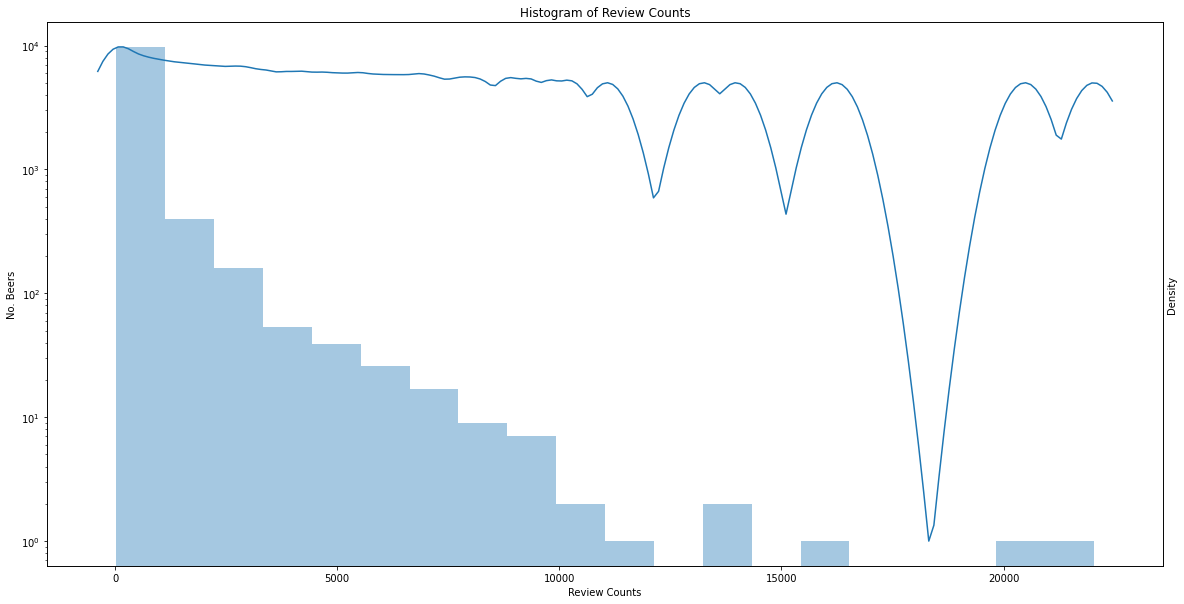

In [17]:
data= df.beer_name.value_counts()

plt.figure(figsize=(20, 10))

# hist without kde
ax = sns.distplot(data, bins=20, kde=False)
plt.yscale('log')

second_ax = ax.twinx()

# kde without hist on a second Y axis
sns.distplot(data, ax=second_ax, kde=True, hist=False)
plt.yscale('log')

second_ax.set_yticks([])

# Set labels
ax.set_xlabel('Review Counts')
ax.set_ylabel('No. Beers')
ax.set_title("Histogram of Review Counts")


In [18]:
grouped_beers = df[['beer_name', 'user_name', 'user_rating']].groupby('beer_name')


In [19]:
grouped_beers.count().sort_values(by='user_name', ascending = False).quantile(np.arange(0, 1, 0.05))


,user_name,user_rating
0.00,27.0,27.0
0.05,61.0,61.0
0.10,75.0,75.0
0.15,75.0,75.0
0.20,75.0,75.0
0.25,77.0,77.0
0.30,100.0,100.0
0.35,100.0,100.0
0.40,110.0,110.0
0.45,125.0,125.0


In [20]:
grouped_beers.mean().sort_values(by='user_rating', ascending = False).quantile(np.arange(0, 1, 0.05))


,user_rating
0.00,1.644160
0.05,3.047048
0.10,3.307200
0.15,3.421699
0.20,3.505600
0.25,3.567600
0.30,3.616800
0.35,3.660466
0.40,3.700584
0.45,3.740210


Text(0.5, 1.0, 'Histogram of User Counts')

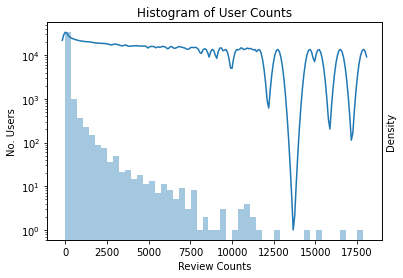

In [21]:
data2 = df.user_name.value_counts()

# Plotting hist without kde
ax2 = sns.distplot(data2, kde=False)
plt.yscale('log')

# Creating another Y axis
second_ax2 = ax2.twinx()

# Plotting kde without hist on the second Y axis
sns.distplot(data2, ax=second_ax2, kde=True, hist=False)
plt.yscale('log')

#Removing Y ticks from the second axis
second_ax2.set_yticks([])

# Set labels
ax2.set_xlabel('Review Counts')
ax2.set_ylabel('No. Users')
ax2.set_title("Histogram of User Counts")

In [22]:
grouped_users = df.groupby('user_name')


In [23]:
grouped_users_count = grouped_users.count()

counts = [1,2,3,4,5,10,15,20, 25, 50, 75, 100, 500, 1000, 10000]
for ct in counts:
    num_users = grouped_users_count[grouped_users_count['user_rating'] <= ct].count()[0]
    print('{} users rated {} or less beers'.format(num_users,ct))

print('\n')
print('Total Unique Users in this dataset: {}'.format(len(df.user_name.unique())))


3200 users rated 1 or less beers
5497 users rated 2 or less beers
9009 users rated 3 or less beers
11552 users rated 4 or less beers
13141 users rated 5 or less beers
18772 users rated 10 or less beers
21308 users rated 15 or less beers
23087 users rated 20 or less beers
24346 users rated 25 or less beers
27592 users rated 50 or less beers
29252 users rated 75 or less beers
30239 users rated 100 or less beers
33942 users rated 500 or less beers
34690 users rated 1000 or less beers
35536 users rated 10000 or less beers


Total Unique Users in this dataset: 35552


In [24]:
df


,brewery_name,beer_name,beer_style,beer_sub_style,user_name,user_rating,rating,rating_count,review_count,ba_score,abv
0,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,StanleysCup,3.77,3.67,3987,1144,83.0,4.3
1,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,TwilightBeerCareer,3.58,3.67,3987,1144,83.0,4.3
2,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,Chipwells,3.50,3.67,3987,1144,83.0,4.3
3,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,GaryM6,3.62,3.67,3987,1144,83.0,4.3
4,Goose Island Beer Co.,Honker's Ale,Pale Ales,Bitter - English,uncleotis,3.82,3.67,3987,1144,83.0,4.3
...,...,...,...,...,...,...,...,...,...,...,...
4026229,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,XmnwildX12,4.73,4.56,896,136,100.0,11.5
4026230,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,Hawkfish,4.62,4.56,896,136,100.0,11.5
4026231,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,Appearanceswc,4.73,4.56,896,136,100.0,11.5
4026232,Funky Buddha Brewery,Last Buffalo In The Park,Porters,Porter - Imperial *,paulish,4.75,4.56,896,136,100.0,11.5


In [25]:
avg_rating = grouped_beers.mean()


# # I am definining beers with average rating less than 3.5 to be considered subpar 
# # since a 3.5 avg rating would put it in the bottom 10 percentile of these beers
subpar_average_mask = avg_rating['user_rating'] < 3.5
subpar_beers_count = len(avg_rating[subpar_average_mask])

print('{} beers have a average rating less than 3.5'.format(subpar_beers_count))
print('A 3.5 avg rating puts the beer within the bottom 10%-tile')


2052 beers have a average rating less than 3.5
A 3.5 avg rating puts the beer within the bottom 10%-tile


In [26]:

bottom_10percent_rating = grouped_beers.mean().quantile(np.arange(0,.11,.01))
bottom_10percent_counts = grouped_beers.count().quantile(np.arange(0,.11,.01))

In [27]:
bottom_10percent_rating


,user_rating
0.00,1.644160
0.01,2.540210
0.02,2.756672
0.03,2.860711
0.04,2.960021
0.05,3.047048
0.06,3.114016
0.07,3.182539
0.08,3.231808
0.09,3.279121


In [28]:
bottom_10percent_counts


,user_name,user_rating
0.00,27.00,27.00
0.01,43.00,43.00
0.02,49.00,49.00
0.03,50.00,50.00
0.04,56.12,56.12
0.05,61.00,61.00
0.06,67.00,67.00
0.07,73.00,73.00
0.08,75.00,75.00
0.09,75.00,75.00


Text(0.5, 1.0, 'Histogram of User Counts')

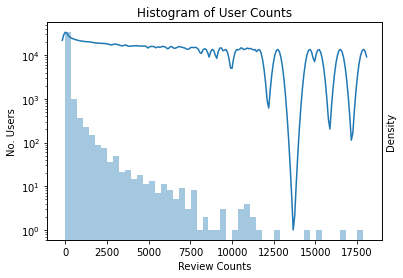

In [29]:
data2= df.user_name.value_counts()

# Plotting hist without kde
ax2 = sns.distplot(data2, kde=False)
plt.yscale('log')

# Creating another Y axis
second_ax2 = ax2.twinx()

# Plotting kde without hist on the second Y axis
sns.distplot(data2, ax=second_ax2, kde=True, hist=False)
plt.yscale('log')
#Removing Y ticks from the second axis
second_ax2.set_yticks([])

# Set labels
ax2.set_xlabel('Review Counts')
ax2.set_ylabel('No. Users')
ax2.set_title("Histogram of User Counts")


In [30]:
grouped_users = df.groupby('user_name')


In [31]:

counts = [1,2,3,4,5,10,15,20]
for ct in counts:
    num_users = grouped_users_count[grouped_users_count['user_rating'] <= ct].count()[0]
    print('{} users rated {} or less beers'.format(num_users,ct))

print('\n')
print('Total Unique Users in this dataset: {}'.format(len(df.user_name.unique())))

3200 users rated 1 or less beers
5497 users rated 2 or less beers
9009 users rated 3 or less beers
11552 users rated 4 or less beers
13141 users rated 5 or less beers
18772 users rated 10 or less beers
21308 users rated 15 or less beers
23087 users rated 20 or less beers


Total Unique Users in this dataset: 35552


In [32]:
subpar_beers_list = list(avg_rating[subpar_average_mask].index)

ratings_count = grouped_beers.count()
ratings_count

# This will be low bcause of some filtering during the data collection 

low_ratings_count = ratings_count[ratings_count['user_rating'] < 50]
low_ratings_list = list(low_ratings_count.index)

In [33]:
unique_subpar_beers = set(subpar_beers_list)
unique_low_ratings_beers = set(low_ratings_list)
overlaps = unique_subpar_beers.intersection(unique_low_ratings_beers)
print('Number of beers in bottom 10% of avg rating: {}'.format(len(unique_subpar_beers)))
print('Number of beers in bottom 10% of review counts: {}'.format(len(unique_low_ratings_beers)))
print('Number of beers in both of these categories: {}'.format(len(overlaps)))


Number of beers in bottom 10% of avg rating: 2052
Number of beers in bottom 10% of review counts: 228
Number of beers in both of these categories: 31


In [34]:
#remove beers in the bottom 10% of both categories
df1 = df[~df.beer_name.isin(subpar_beers_list)]
df2 = df1[~df1.beer_name.isin(low_ratings_list)]
final_df = copy.deepcopy(df2)


In [35]:
final_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3405148 entries, 0 to 4026233
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   brewery_name    string 
 1   beer_name       string 
 2   beer_style      string 
 3   beer_sub_style  string 
 4   user_name       string 
 5   user_rating     float64
 6   rating          float64
 7   rating_count    Int64  
 8   review_count    Int64  
 9   ba_score        float64
 10  abv             float64
dtypes: Int64(2), float64(4), string(5)
memory usage: 318.2 MB


In [36]:
print('Original number of unique beers: {}'.format(len(df.beer_name.unique())))

print('Revised number of unique beers: {}'.format(len(final_df.beer_name.unique())))

Original number of unique beers: 10465
Revised number of unique beers: 8216


Text(0.5, 1.0, 'Rating Distribution')

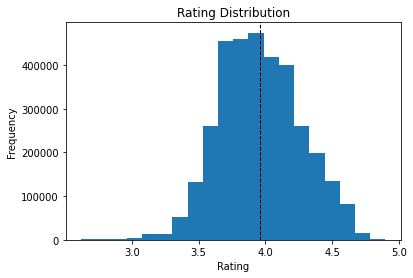

In [39]:
ax = final_df.rating.plot(kind='hist', bins=20)
plt.axvline(final_df.rating.mean(), color='k', linestyle='dashed', linewidth=1)
ax.set_xlabel('Rating')
ax.set_ylabel('Frequency')
ax.set_title("Rating Distribution")

In [38]:
filename = '../data/processed/final_beer_df.plk'
final_df.to_pickle(filename)